In [1]:
import configparser
import pathlib as path
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from idao.data_module import IDAODataModule
from idao.model import SimpleConv
import numpy as np
import torch
import os
import pathlib as path
from PIL import Image

from torchvision.datasets import DatasetFolder
from torch.utils.data import Dataset
import pathlib as path

import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F

import configparser
import pathlib as path

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

import configparser
import gc
import logging
import pathlib as path
import sys
from collections import defaultdict
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt
import torch
from more_itertools import bucket

#from idao.data_module import IDAODataModule
#from idao.model import SimpleConv
from idao.utils import delong_roc_variance


In [2]:
class IDAODataset(DatasetFolder):
    def name_to_energy(self, name):
        names = os.path.split(name)[-1].split("_")
        idx = [i for i, v in enumerate(names) if v == "keV"][0]
        return torch.tensor(float(names[idx - 1]))

    def name_to_index(self, name):
        return os.path.split(name)[-1].split('.')[0]

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, self.name_to_energy(path), self.name_to_index(path)

class InferenceDataset(Dataset):
    def __init__(self, main_dir, transform, loader=None):
        self.img_loaderj= img_loader
        self.main_dir = path.Path(main_dir)
        self.transform = transform
        self.all_imgs = list(self.main_dir.glob("*.png"))
        self.loader = loader

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = self.all_imgs[idx]
        image = self.loader(img_loc)
        tensor_image = self.transform(image)
        return tensor_image, img_loc.name

def img_loader(path: str):
    with Image.open(path) as img:
        img = np.array(img)
    return img


In [3]:
class IDAODataModule(pl.LightningDataModule):
    def __init__(self, data_dir: path.Path, batch_size: int, cfg):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.cfg = cfg

    def prepare_data(self):
        # called only on 1 GPU
        self.dataset = IDAODataset(
            root=self.data_dir.joinpath("train"),
            loader=img_loader,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.CenterCrop(120)]  #CenterCrop(160)
            ),
            # TODO(kazeevn) use idiomatic torch
            target_transform=transforms.Compose(
                [
                    lambda num: (
                        torch.tensor([0, 1]) if num == 0 else torch.tensor([1, 0])
                    )
                ]
            ),
            extensions=self.cfg["DATA"]["Extension"],
        )

        self.test = InferenceDataset(
                    main_dir=self.data_dir.joinpath("test"),
                    loader=img_loader,
                    transform=transforms.Compose(
                        [transforms.ToTensor(), transforms.CenterCrop(120)]#CenterCrop(160)
                    ),
                )


    def setup(self, stage=None):
        # called on every GPU
        self.train, self.val = random_split(
            self.dataset, [10000, 3404], generator=torch.Generator().manual_seed(666)
        )

    def train_dataloader(self):
        return DataLoader(self.train, self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, 1, num_workers=1, shuffle=False)
    

    def test_dataloader(self):
        return DataLoader(
            self.test,
            self.batch_size,
            num_workers=0,
            shuffle=False
            )



In [4]:
class Print(nn.Module):
    """Debugging only"""

    def forward(self, x):
        print(x.size())
        return x


class Clamp(nn.Module):
    """Clamp energy output"""

    def forward(self, x):
        x = torch.clamp(x, min=0, max=30)
        return x


class SimpleConv(pl.LightningModule):
    def __init__(self, mode: ["classification", "regression"] = "classification"):
        super().__init__()
        self.mode = mode
        self.layer1 = nn.Sequential(
                    nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
                    nn.BatchNorm2d(16),
                    nn.ReLU(),
                    nn.MaxPool2d(6),
                    nn.Conv2d(16,32,4,stride=1,padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=6,stride=3),
                    nn.Flatten(),
                )
        

        self.drop_out = nn.Dropout(p=0.4)

        self.fc1 = nn.Linear(800, 200)
        self.fc2 = nn.Linear(200, 2)  # for classification
        self.fc3 = nn.Linear(200, 1)  # for regression

        self.stem = nn.Sequential(
            self.layer1, self.drop_out, self.fc1,
            )
        if self.mode == "classification":
            self.classification = nn.Sequential(self.stem, self.fc2)
        else:
            self.regression = nn.Sequential(self.stem, self.fc3)

        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()

    def training_step(self, batch, batch_idx):
        # --------------------------
        x_target, class_target, reg_target, _ = batch
        if self.mode == "classification":
            class_pred = self.classification(x_target.float())
            class_loss = F.binary_cross_entropy_with_logits(
                class_pred, class_target.float()
            )
            self.train_acc(torch.sigmoid(class_pred), class_target)
            self.log("train_acc", self.train_acc, on_step=True, on_epoch=False)
            self.log("classification_loss", class_loss)

            return class_loss

        else:
            reg_pred = self.regression(x_target.float())
            #             reg_loss = F.l1_loss(reg_pred, reg_target.float().view(-1, 1))
            reg_loss = F.mse_loss(reg_pred, reg_target.float().view(-1, 1))

            #             reg_loss = torch.sum(torch.abs(reg_pred - reg_target.float().view(-1, 1)) / reg_target.float().view(-1, 1))
            self.log("regression_loss", reg_loss)
            return reg_loss

    def training_epoch_end(self, outs):
        # log epoch metric
        if self.mode == "classification":
            self.log("train_acc_epoch", self.train_acc.compute())
        else:
            pass

    def validation_step(self, batch, batch_idx):
        x_target, class_target, reg_target, _ = batch
        if self.mode == "classification":
            class_pred = self.classification(x_target.float())
            class_loss = F.binary_cross_entropy_with_logits(
                class_pred, class_target.float()
            )
            self.valid_acc(torch.sigmoid(class_pred), class_target)
            self.log("valid_acc", self.valid_acc.compute())
            self.log("classification_loss", class_loss)
            return class_loss

        else:
            reg_pred = self.regression(x_target.float())
            #             reg_loss = F.l1_loss(reg_pred, reg_target.float().view(-1, 1))
            reg_loss = F.mse_loss(reg_pred, reg_target.float().view(-1, 1))

            #             reg_loss = torch.sum(torch.abs(reg_pred - reg_target.float().view(-1, 1)) / reg_target.float().view(-1, 1))
            self.log("regression_loss", reg_loss)
            return reg_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adamax(self.parameters(), lr=1e-3)
        return optimizer

    def forward(self, x):
        if self.mode == "classification":
            class_pred = self.classification(x.float())
            return {"class": torch.sigmoid(class_pred)}
        else:
            reg_pred = self.regression(x.float())
            return {"energy": reg_pred}


In [5]:
def test_variance(target, predictions):
    return torch.std(torch.abs(predictions - target) / target) ** 2


def run_test(mode, dataloader, checkpoint_path, cfg):
    torch.multiprocessing.set_sharing_strategy("file_system")
    logging.info("Loading checkpoint")
    model = SimpleConv.load_from_checkpoint(checkpoint_path, mode=mode)
    model = model.cpu().eval()
    regression_predictions = []
    classification_predictions = []
    classification_target = []
    regression_target = []

    if mode == "classification":
        logging.info("Classification model loaded")
    else:
        logging.info("Regression model loaded")

    for i, (img, class_label, regression_label, _) in enumerate(iter(dataloader)):
        if mode == "classification":
            output = model(img)["class"].detach()
            classification_predictions.append(output)
            classification_target.append(class_label)
        else:
            output = model(img)["energy"].detach()
            regression_predictions.append(output)
            regression_target.append(regression_label)

    #        del output

    if mode == "classification":
        logging.info("Starting classification task")
        classification_predictions = torch.cat(classification_predictions, dim=0)
        classification_target = torch.cat(classification_target, dim=0)
        new_target = np.argmax(classification_target.detach().cpu().numpy(), axis=1)
        auc, variance = delong_roc_variance(
            new_target, classification_predictions.detach().cpu().numpy()[:, 1]
        )
        skplt.metrics.plot_roc(
            classification_target.max(1).indices,
            classification_predictions.detach().cpu().numpy(),
            plot_macro=False,
            plot_micro=False,
            classes_to_plot=[0]
        )
        plt.savefig(f'{cfg["REPORT"]["SaveDir"]}/roc_auc.png', dpi=196)
        plt.show()
        logging.info(f'ROC plot saved at: {cfg["REPORT"]["SaveDir"]}/roc_auc.png')
        logging.info(f"Delong => ROC-AUC: {auc} variance: {variance}")

        del classification_predictions
        del classification_target
        # gc.collect() # Invoke the garbage collector
        return (None, auc)

    else:
        logging.info("Starting regression task")
        regression_predictions = torch.tensor(
            list(chain(*regression_predictions))
        ).view(-1)
        regression_target = torch.tensor(list(chain(*regression_target))).view(-1)
        variance = test_variance(regression_target, regression_predictions)
        #plt.savefig(f'{cfg["REPORT"]["SaveDir"]}/roc_auc.png', dpi=196)
        #plt.show()
        logging.info(f"Test energy variance: {variance}")

        # MAE
        mae = torch.nn.functional.l1_loss(regression_predictions, regression_target)

        # plot correlation
        fig, ax = plt.subplots()
        ax.plot(
            regression_target, regression_predictions, "ro", label="Energy Prediction"
        )
        ax.set_xlabel("True Energy")
        ax.set_ylabel("Predicted Energy")
        ax.legend()
        ax.grid()
        fig.savefig(f'{cfg["REPORT"]["SaveDir"]}/energy_correlation.png', dpi=196)
        logging.info(f'Energy correlation plot saved at: {cfg["REPORT"]["SaveDir"]}/energy_correlation.png')
        plt.show(fig)
        plt.close(fig)

        logging.info(f'===> Length: {len(regression_predictions)} {len(regression_target)}')
        # plot comparison
        fig1, ax1 = plt.subplots()
        ax1.plot(regression_predictions, "bo", alpha=0.6, label="Predicted Energy")
        ax1.plot(regression_target, "ro", label="True Energy")
        ax1.legend()
        ax1.grid()
        fig1.savefig(f'{cfg["REPORT"]["SaveDir"]}/energy_comparison.png', dpi=196)
        logging.info(f'Energy comparison plot saved at: {cfg["REPORT"]["SaveDir"]}/energy_comparison.png')
        plt.show(fig1)
        plt.close(fig1)

        # plot histograms
        group = zip(regression_target, regression_predictions)
        group = sorted(group, key=lambda item: item[0])
        logging.info(regression_target)

        data_dict = defaultdict(list)

        for t, p in group:
            data_dict[t.item()].append(p.item())

        for i, (k, v) in enumerate(data_dict.items()):
            fig3, ax3 = plt.subplots()
            ax3.hist(
                v,
                bins=100,
                histtype="step",
                label=f"Energy: {k} keV \n RMS: {float(torch.sqrt(torch.mean(torch.tensor(v)**2))):.03f} \n Mean: {float(torch.mean(torch.tensor(v))):.03f}",
            )
            ax3.legend()
            fig3.savefig(f'{cfg["REPORT"]["SaveDir"]}/energy_hist{k}_{i}.png', dpi=196)
            plt.close(fig3)

            logging.info(
                f'Histogram {k} keV saved at: {cfg["REPORT"]["SaveDir"]}/energy_hist{k}_{i}.png'
            )

        return (mae, None)


In [6]:
def main(cfg):
    PATH = path.Path(cfg["DATA"]["DatasetPath"])

    dataset_dm = IDAODataModule(
        data_dir=PATH, batch_size=64, cfg=cfg
    )

    dataset_dm.prepare_data()
    dataset_dm.setup()
    dl = dataset_dm.train_dataloader()
    mae = 0
    variance = 0

    for mode in ["regression", "classification"]:
        if mode == "classification":
            model_path = cfg["REPORT"]["ClassificationCheckpoint"]
        else:
            model_path = cfg["REPORT"]["RegressionCheckpoint"]

        _mae, _auc = run_test(mode, dl, model_path, cfg=cfg)
        if _mae is not None:
            mae = _mae
        if _auc is not None:
            auc = _auc


        gc.collect()
    logging.info(f'MAE = {mae}')
    logging.info(f'AUC = {auc}')



INFO:root:Loading checkpoint


INFO:root:Regression model loaded


/usr/local/lib/python3.6/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning:

The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)



INFO:root:Starting regression task


INFO:root:Test energy variance: 0.07867857813835144


INFO:root:Energy correlation plot saved at: ./results/energy_correlation.png


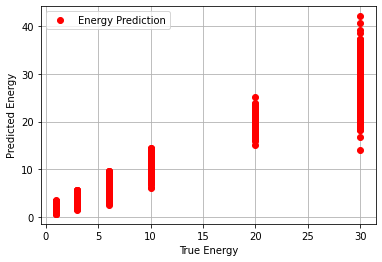

INFO:root:===> Length: 10000 10000


INFO:root:Energy comparison plot saved at: ./results/energy_comparison.png


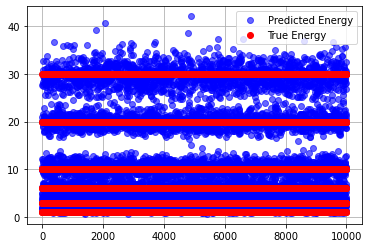

INFO:root:tensor([20., 20., 10.,  ..., 30.,  3., 10.])


INFO:root:Histogram 1.0 keV saved at: ./results/energy_hist1.0_0.png


INFO:root:Histogram 3.0 keV saved at: ./results/energy_hist3.0_1.png


INFO:root:Histogram 6.0 keV saved at: ./results/energy_hist6.0_2.png


INFO:root:Histogram 10.0 keV saved at: ./results/energy_hist10.0_3.png


INFO:root:Histogram 20.0 keV saved at: ./results/energy_hist20.0_4.png


INFO:root:Histogram 30.0 keV saved at: ./results/energy_hist30.0_5.png


INFO:root:Loading checkpoint

INFO:root:Classification model loaded


INFO:root:Starting classification task


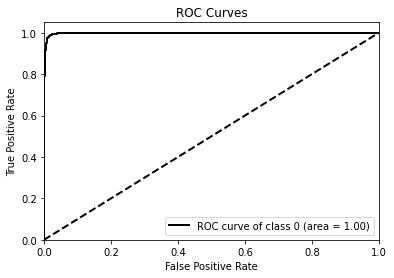

INFO:root:ROC plot saved at: ./results/roc_auc.png


INFO:root:Delong => ROC-AUC: 0.9988354291488191 variance: 2.5425233487206194e-08


INFO:root:MAE = 1.0484306812286377


INFO:root:AUC = 0.9988354291488191


In [7]:
if __name__ == "__main__":
    config = configparser.ConfigParser()
    config.read("./config.ini")

    logging.basicConfig(
        level=logging.INFO,
        handlers=[
            logging.FileHandler(f'{config["REPORT"]["SaveDir"]}report.log'),
            logging.StreamHandler(sys.stdout),
        ],
    )
    main(cfg=config)